# Когортный анализ Retention и RFM сегментация
Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:  
1. Сколько у нас пользователей, которые совершили покупку только один раз?  
2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?   
3. По каждому товару определить, в какой день недели товар чаще всего покупается.  
4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.  
5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.
6. Часто для качественного анализа аудитории используют подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 

    В кластеризации можешь выбрать следующие метрики:  
    R - время от последней покупки пользователя до текущей даты  
    F - суммарное количество покупок у пользователя за всё время  
    M - сумма покупок за всё время.  
    Подробно опиши, как ты создавал кластеры.  
    Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.
    
**Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.**  

## Получаем и анализируем исходные данные

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set(style='whitegrid', rc={'figure.figsize': (16,6)})

### df_customers (таблица с уникальными идентификаторами пользователей)  

customer_id — позаказный идентификатор пользователя  
customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)  
customer_zip_code_prefix —  почтовый индекс пользователя  
customer_city —  город доставки пользователя  
customer_state —  штат доставки пользователя  

In [4]:
df_customers = pd.read_csv('olist_customers_dataset.csv')
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


### olist_orders_dataset.csv (таблица заказов)

order_id —  уникальный идентификатор заказа (номер чека)  
customer_id —  позаказный идентификатор пользователя  
order_status —  статус заказа  
order_purchase_timestamp —  время создания заказа  
order_approved_at —  время подтверждения оплаты заказа  
order_delivered_carrier_date —  время передачи заказа в логистическую службу  
order_delivered_customer_date —  время доставки заказа  
order_estimated_delivery_date —  обещанная дата доставки  

Уникальные статусы заказов в таблице olist_orders_dataset:  
created —  создан  
approved —  подтверждён  
invoiced —  выставлен счёт  
processing —  в процессе сборки заказа  
shipped —  отгружен со склада  
delivered —  доставлен пользователю  
unavailable —  недоступен  
canceled —  отменён  

In [5]:
dates_orders = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
df_orders = pd.read_csv('olist_orders_dataset.csv', parse_dates=dates_orders)
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


### olist_order_items_dataset.csv (товарные позиции, входящие в заказы) 

order_id —  уникальный идентификатор заказа (номер чека)  
order_item_id —  идентификатор товара внутри одного заказа  
product_id —  ид товара (аналог штрихкода)  
seller_id — ид производителя товара  
shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике  
price —  цена за единицу товара  
freight_value —  вес товара  

In [57]:
df_order_items = pd.read_csv('olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


## Предварительное исследование данных
Посмотрим на отсутствующие значения в данных df_orders и попробуем их интерпретировать:

In [58]:
stat_ord = df_orders.order_status.unique() # список статусов
isn = df_orders.isna().sum().to_frame('val')
col_ord = isn[isn.val != 0].index.to_list() # колонки
data = []

for status in stat_ord:
    row = []
    for column in col_ord:
        value = df_orders[df_orders.order_status == status][column].isna().sum()
        row.append(value)  
    row.insert(0, df_orders[df_orders.order_status == status].shape[0]) # добавляем значение row_values
    row.insert(0, status) # добавляем значение status
    data.append(row) 
    
col_ord.insert(0, 'row_values') 
col_ord.insert(0, 'status')
df = pd.DataFrame(data, columns=col_ord)
df

,status,row_values,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date
0,delivered,96478,14,2,8
1,invoiced,314,0,314,314
2,shipped,1107,0,0,1107
3,processing,301,0,301,301
4,unavailable,609,0,609,609
5,canceled,625,141,550,619
6,created,5,5,5,5
7,approved,2,0,2,2


Попробуем объяснить полученые значения:

96478 - доставлен пользователю  
14 - (доставлен пользователю, нет время подтверждения оплаты заказа) - не оплачен, но доставлен (проверить поступление оплаты)   
2 - (доставлен пользователю, нет время передачи заказа в логистическую службу) - не списан но доставлен (заполнить документы склад)  
8 - (доставлен пользователю, нет время доставки заказа) - не заполнили время доставки (заполнить документы доставку)   

625 - отменены
619 - (отменены, нет время доставки заказа) - (6 заказов были доставлены, при этом статус отменен)

Остальные причины пропущеных значений очевидны.

Критичны две ошибки:  
14 заказов не были оплачены (возможно махинации с выводом средств или хищением товаров со склада)  
6 заказов были доставлены, но находятся в статусе отмены (проверить состояние списания со счетов, провести инвентаризацию склада)

## 1. Сколько у нас пользователей, которые совершили покупку только один раз?

Помним что у каждый customer_unique_id потенциально может содержать несколько customer_id  
Также будем использовать только delivered в силу того что мы не можем быть уверены в окончательности совершенной покупки у остальных статусов  
Для подсчета покупок на пользователя объединим таблицы df_customers и df_orders  

In [59]:
one_purchase = df_orders[['customer_id']][df_orders.order_status == 'delivered'] \
    .merge(df_customers[['customer_id', 'customer_unique_id']], on='customer_id') \
    .groupby('customer_unique_id').agg({'customer_id': 'count'}).reset_index()

print(one_purchase[one_purchase.customer_id == 1].shape[0], 'пользователей совершили покупку только один раз.')

90557 пользователей совершили покупку только один раз.


## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Из статусов причин не доставленных товаров мы выбрали:  
unavailable —  недоступен  
canceled —  отменён  
В качестве даты мы выбираем order_purchase_timestamp

Переведём даты к началу месяца и сгруппируем по статусам и по месяцам

In [60]:
df_orders['date'] = df_orders.order_purchase_timestamp.dt.strftime('%Y-%m')

undelivered = df_orders[(df_orders.order_status == 'unavailable') | (df_orders.order_status == 'canceled')] \
    .groupby(['order_status', 'date']).agg({'order_id': 'count'}).rename(columns={'order_id': 'orders'}).reset_index()
undelivered.head()

,order_status,date,orders
0,canceled,2016-09,2
1,canceled,2016-10,24
2,canceled,2017-01,3
3,canceled,2017-02,17
4,canceled,2017-03,33


Для наглядности создадим график не выполненных и отменённых заказов по месяцам

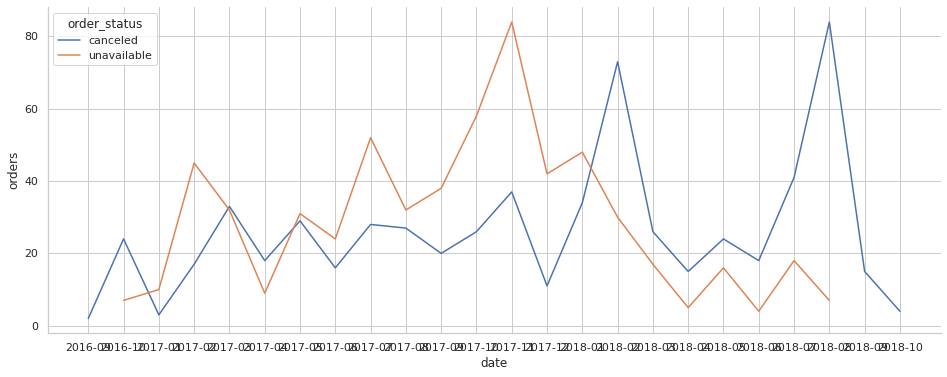

In [61]:
sns.lineplot(data=undelivered, x='date', y ='orders', hue='order_status')
sns.despine()

In [62]:
undelivered = undelivered.groupby('order_status').mean().round().reset_index()
print('В среднем в месяц не доставляются по причинам:\n{} отменены\n{} нет в наличии'.format(int(undelivered[undelivered.order_status == 'canceled'].values[0][1]), int(undelivered[undelivered.order_status == 'unavailable'].values[0][1])))

В среднем в месяц не доставляются по причинам:
26 отменены
29 нет в наличии


## 3 По каждому товару определить, в какой день недели товар чаще всего покупается.

Для подсчета мы будем анализировать таблицу df_order_items  
Мы выяснили что покупатели могут приобретать в одной покупке несколько товаров.  
Так как в вопросе не сказано конкретно что является покупкой, мы будем считать что речь идет о частоте уникальных покупок товара а не о проданном количестве.  
В этом случае нам необходимо сгруппировать в покупки по order_id и product_id

In [63]:
orders_products = df_order_items.groupby(['order_id', 'product_id']) \
    .agg({'order_item_id': 'count'}) \
    .rename(columns={'order_item_id': 'count_in_order'}).reset_index()
orders_products.sort_values('count_in_order').tail()

,order_id,product_id,count_in_order
61929,9bdc4d4c71aa1de4606060929dee888c,44a5d24dd383324a421569ca697b13c2,14
63242,9ef13efd6949e4573a18964dd1bbe7f5,37eb69aca8718e843d897aa7b82f462d,15
26550,428a2f660dc84138d969ccd69a0ab6d5,89b190a046022486c635022524a974a8,15
10850,1b15974a0141d54e36626dca3fdc731a,ee3d532c8a438679776d222e997606b3,20
68186,ab14fdcfbe524636d65ee38360e22ce8,9571759451b1d780ee7c15012ea109d4,20


Нам необходимо получить даты продажи и мы их возьмём из df_orders  
Также стоит учесть что товар может быть отменён или отсутствовать, а также заказы в точности завершения продажи которых мы не можем быть уверены. Поэтому мы отберём только те у которых статус delivered  
Добавим столбец weekday

In [64]:
orders_dates = df_orders[df_orders.order_status == 'delivered'].groupby('order_id') \
    .agg({'order_purchase_timestamp': 'first'}).reset_index() \
    .sort_values('order_purchase_timestamp').set_index('order_purchase_timestamp')

orders_dates['weekday'] = pd.to_datetime(orders_dates.index).day_name()
orders_dates.head()

,order_id,weekday
order_purchase_timestamp,,
2016-09-15 12:16:38,bfbd0f9bdef84302105ad712db648a6c,Thursday
2016-10-03 09:44:50,3b697a20d9e427646d92567910af6d57,Monday
2016-10-03 16:56:50,be5bc2f0da14d8071e2d45451ad119d9,Monday
2016-10-03 21:13:36,a41c8759fbe7aab36ea07e038b2d4465,Monday
2016-10-03 22:06:03,d207cc272675637bfed0062edffd0818,Monday


Объединим таблицы orders_products и orders_dates

In [65]:
orders_products_dates = orders_products.merge(orders_dates, on='order_id')
orders_products_dates.head()

,order_id,product_id,count_in_order,weekday
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,1,Wednesday
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,1,Wednesday
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,1,Sunday
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,1,Wednesday
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,1,Saturday


Группируем product_id по дням недели и выбирем день недели с максимальным числом покупок.  
Обращаем внимание что если максимальное количество вхождений встречается более одного раза мы получаем список дней с максимальным числом покупок.

In [66]:
orders_products_dates = orders_products_dates.groupby(['product_id']).weekday.agg(pd.Series.mode)
orders_products_dates

product_id
00066f42aeeb9f3007548bb9d3f33c38                 Sunday
00088930e925c41fd95ebfe695fd2655                Tuesday
0009406fd7479715e4bef61dd91f2462               Thursday
000b8f95fcb9e0096488278317764d19    [Friday, Wednesday]
000d9be29b5207b54e86aa1b1ac54872                Tuesday
                                           ...         
fff6177642830a9a94a0f2cba5e476d1     [Saturday, Sunday]
fff81cc3158d2725c0655ab9ba0f712c                 Monday
fff9553ac224cec9d15d49f5a263411f                 Friday
fffdb2d0ec8d6a61f0a0a0db3f25b441                Tuesday
fffe9eeff12fcbd74a2f2b007dde0c58              Wednesday
Name: weekday, Length: 32216, dtype: object

Series с product_id и днем недели в который чаще всего покупается товар в переменной orders_products_dates

## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?
(Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.)

Так как в задаче слово 'покупка' не уточняет что это: количество купленных товаров или количество чеков, мы выбрали определением количество чеков.  
Сперва получаем таблицу с customer_unique_id и order_id как и в задании 1

In [67]:
df_orders_customers_4 = df_orders.merge(df_customers[['customer_id', 'customer_unique_id']], on='customer_id')
df_orders_customers_4.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02,72632f0f9dd73dfee390c9b22eb56dd6


Выбирем только те что уже доставлены (order_status == delivered) и сгруппируем по покупкам.  
Нормализуем дату на 1 число месяца.  
Добавим колонку количества недель в месяце week_in_month

In [68]:
df_orders_customers_4 = df_orders_customers_4[df_orders_customers_4.order_status == 'delivered'] \
    .groupby('order_id').agg({'order_purchase_timestamp': 'first', 'customer_unique_id': 'first'}).reset_index()

df_orders_customers_4['week_in_month'] = df_orders_customers_4.order_purchase_timestamp.dt.daysinmonth / 7
df_orders_customers_4['order_purchase_timestamp'] = df_orders_customers_4.order_purchase_timestamp.dt.normalize() - pd.offsets.MonthBegin(1)
df_orders_customers_4.head()

,order_id,order_purchase_timestamp,customer_unique_id,week_in_month
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-01,871766c5855e863f6eccc05f988b23cb,4.285714
1,00018f77f2f0320c557190d7a144bdd3,2017-04-01,eb28e67c4c0b83846050ddfb8a35d051,4.285714
2,000229ec398224ef6ca0657da4fc703e,2018-01-01,3818d81c6709e39d06b2738a8d3a2474,4.428571
3,00024acbcdf0a6daa1e931b038114c75,2018-08-01,af861d436cfc08b2c2ddefd0ba074622,4.428571
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-01,64b576fb70d441e8f1b2d7d446e483c5,4.000000


Сгруппируем покупки, чтобы получить заказов в месяц order_id у customer_unique_id

In [69]:
df_orders_customers_4 = df_orders_customers_4.groupby(['customer_unique_id', 'order_purchase_timestamp']) \
    .agg({'order_id': 'count', 'week_in_month': 'first'}).reset_index()
df_orders_customers_4.head()

,customer_unique_id,order_purchase_timestamp,order_id,week_in_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1,4.428571
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1,4.428571
2,0000f46a3911fa3c0805444483337064,2017-03-01,1,4.428571
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1,4.428571
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1,4.285714


Считаем среднее количество покупок в неделю на каждого пользователя с разбивкой по месяцам orders_in_week(order_id)  
Удаляем колонку week_in_month  
Переименовываем в month_of_purchase orders_in_week

In [70]:
df_orders_customers_4['order_id'] = df_orders_customers_4.order_id / df_orders_customers_4.week_in_month
df_orders_customers_4 = df_orders_customers_4.drop(columns='week_in_month')
df_orders_customers_avg = df_orders_customers_4 \
    .rename(columns={'order_id': 'orders_in_week', 'order_purchase_timestamp': 'month_of_purchase'}) \
    .sort_values('month_of_purchase')

Посмотрим среднее значение всех пользователей по месяцам

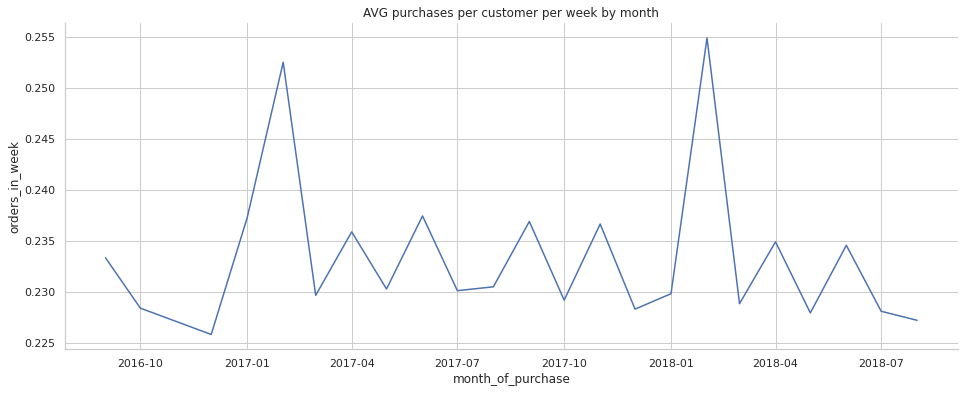

In [71]:
pcwm = df_orders_customers_avg.groupby('month_of_purchase').agg({'orders_in_week': 'mean'})
sns.lineplot(data=pcwm, x='month_of_purchase', y ='orders_in_week') \
    .set(title='AVG purchases per customer per week by month')
sns.despine()

Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам) в переменной df_orders_customers_avg  
Dataframe с пользователем (customer_unique_id) среднем покупок в неделю (orders_in_week) по месяцам (month_of_purchase)

In [72]:
df_orders_customers_avg.head()

,customer_unique_id,month_of_purchase,orders_in_week
48807,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-01,0.233333
8127,15896826233a6eda72c64e1b99a0856a,2016-10-01,0.225806
49155,840048bff3cbd6d92d97a3816521222e,2016-10-01,0.225806
82809,de51ac050e580a6f05fdf0d56fac2cef,2016-10-01,0.225806
49307,84717d840af87a7fa12a66a0933ede2a,2016-10-01,0.225806


## 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

order_id = customer_id  
order_id —  уникальный идентификатор заказа (номер чека)   
customer_id — позаказный идентификатор пользователя   
customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)  

Так как когорты мы создаём по месяцам - создадим столбец с месяцем покупки

In [73]:
df_orders['purchase_month'] = df_orders.order_purchase_timestamp.dt.strftime('%Y-%m')
#df_orders['purchase_month'] = df_orders.order_purchase_timestamp.dt.normalize() - pd.offsets.MonthBegin(1)
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,date,purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02,2018-02


Нам понадобятся данные о покупателях (customer_unique_id), покупках (order_id), дате покупки(purchase_month).  
Мы будем учитывать только совершенные покупки delivered

In [74]:
cust_order = df_orders[df_orders.order_status == 'delivered'].merge(df_customers, on='customer_id') \
    [['order_id', 'customer_unique_id', 'purchase_month']]
cust_order.head()

,order_id,customer_unique_id,purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,2018-02


In [75]:
cust_order.shape

(96478, 3)

Для построения когорты в условии задачи сказано "В период с января по декабрь" но не указано в какой год.  

In [76]:
cust_order.purchase_month.min(), cust_order.purchase_month.max()

('2016-09', '2018-08')

Мы посмотрели все заказы и предположили что "В период с января по декабрь" должен быть с '2017-01' по '2017-12'  
Создадим таблицу first_purchase первой покупки с '2017-01' по '2017-12' 

In [77]:
first_purchase = cust_order[(cust_order.purchase_month >= '2017-01') & (cust_order.purchase_month <= '2017-12')] \
    .groupby('customer_unique_id').agg({'purchase_month': 'min'}) \
    .rename(columns={'purchase_month': 'cohort'}).reset_index()

first_purchase.head()

,customer_unique_id,cohort
0,0000f46a3911fa3c0805444483337064,2017-03
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10
2,0004aac84e0df4da2b147fca70cf8255,2017-11
3,0005e1862207bf6ccc02e4228effd9a0,2017-03
4,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07


Добавим first_purchase в таблицу cust_order (заодно избавимся от строк периода не входящего в когорту)

In [78]:
cust_order = cust_order[cust_order.purchase_month >= '2017-01'].merge(first_purchase, on='customer_unique_id')
cust_order.head()

,order_id,customer_unique_id,purchase_month,cohort
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-09
1,69923a4e07ce446644394df37a710286,7c396fd4830fd04220f754e42b4e5bff,2017-09,2017-09
2,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11
3,a4591c265e18cb1dcee52889e2d8acc3,80bb27c7c16e8f973207a5086ab329e2,2017-07,2017-07
4,6514b8ad8028c9f2cc2374ded245783f,932afa1e708222e5821dac9cd5db4cae,2017-05,2017-05


In [79]:
cust_order.shape

(44144, 4)

Посчитаем размеры когорт.

In [80]:
sizes_cohort = cust_order.groupby('cohort').agg({'customer_unique_id': 'nunique'}) \
    .rename(columns={'customer_unique_id':'initial_users'}).reset_index()
sizes_cohort.head()

,cohort,initial_users
0,2017-01,718
1,2017-02,1628
2,2017-03,2503
3,2017-04,2257
4,2017-05,3451


Посчитаем уникальных покупателей по месяцам в разных когортах.

In [81]:
sizes_month = cust_order.groupby(['purchase_month', 'cohort']).agg({'customer_unique_id': 'nunique'}).reset_index()
sizes_month.head()

,purchase_month,cohort,customer_unique_id
0,2017-01,2017-01,718
1,2017-02,2017-01,2
2,2017-02,2017-02,1628
3,2017-03,2017-01,2
4,2017-03,2017-02,3


Посчитаем Retention Rate, для этого объединим sizes_cohort и sizes_month, а также создадим столбец RR

In [82]:
cohort = sizes_month.merge(sizes_cohort, on='cohort')
cohort['RR'] = round(cohort.customer_unique_id / cohort.initial_users, 5)
cohort.head()

,purchase_month,cohort,customer_unique_id,initial_users,RR
0,2017-01,2017-01,718,718,1.00000
1,2017-02,2017-01,2,718,0.00279
2,2017-03,2017-01,2,718,0.00279
3,2017-04,2017-01,1,718,0.00139
4,2017-05,2017-01,3,718,0.00418


In [83]:
#cohort['delta'] = (cohort.purchase_month - cohort.cohort).astype('timedelta64[M]').astype(int)
cohort['delta'] = pd.to_datetime(cohort.purchase_month).dt.to_period('M').view(dtype='int64') - pd.to_datetime(cohort.cohort).dt.to_period('M').view(dtype='int64')
cohort.head()

,purchase_month,cohort,customer_unique_id,initial_users,RR,delta
0,2017-01,2017-01,718,718,1.00000,0
1,2017-02,2017-01,2,718,0.00279,1
2,2017-03,2017-01,2,718,0.00279,2
3,2017-04,2017-01,1,718,0.00139,3
4,2017-05,2017-01,3,718,0.00418,4


In [84]:
result = cohort[cohort.delta != 0][['cohort', 'delta', 'RR']] \
    .pivot_table(index='cohort', columns='delta', values='RR', aggfunc='sum') 
result.head()

delta,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
cohort,,,,,,,,,,,,,,,,,,
2017-01,0.00279,0.00279,0.00139,0.00418,0.00139,0.00418,0.00139,0.00139,NaN,0.00418,0.00139,0.00696,0.00418,0.00139,0.00139,0.00279,0.00418,0.00139
2017-02,0.00184,0.00307,0.00123,0.00430,0.00123,0.00246,0.00184,0.00123,0.00184,0.00123,0.00307,0.00123,0.00184,0.00123,0.00061,0.00061,0.00184,NaN
2017-03,0.00439,0.00360,0.00400,0.00360,0.00160,0.00160,0.00320,0.00320,0.00080,0.00360,0.00120,0.00200,0.00120,0.00160,0.00240,0.00080,0.00120,NaN
2017-04,0.00620,0.00222,0.00177,0.00266,0.00266,0.00354,0.00310,0.00310,0.00177,0.00266,0.00089,0.00044,0.00044,0.00089,0.00089,0.00133,NaN,NaN
2017-05,0.00464,0.00464,0.00290,0.00290,0.00319,0.00406,0.00145,0.00261,0.00261,0.00261,0.00348,0.00232,0.00029,0.00174,0.00203,NaN,NaN,NaN


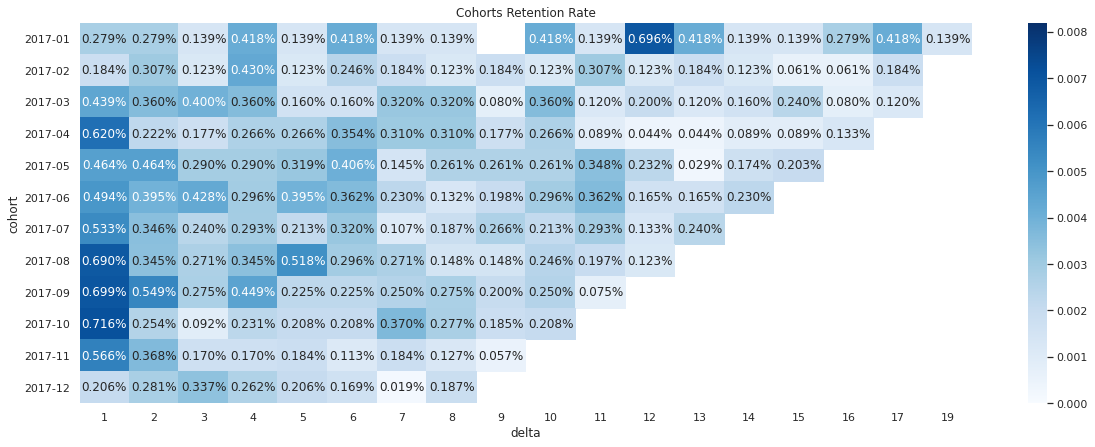

In [85]:
plt.figure(figsize=(20, 7))
plt.title('Cohorts Retention Rate')
sns.heatmap(data=result, fmt='.3%', vmin = 0.0, vmax = 0.0082, annot=True, cmap='Blues')
plt.show()

In [86]:
max_retention = cohort[cohort.RR == cohort[cohort.delta == 3].RR.max()].cohort.values[0]
print('В период с января по декабрь 2017 года с самым высоким retention на 3й месяц\nбыла группа покупателей совершивших первую покупку {}'.format(max_retention))

В период с января по декабрь 2017 года с самым высоким retention на 3й месяц
была группа покупателей совершивших первую покупку 2017-06


## 6 Часто для качественного анализа аудитории используют подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.

Подробно опиши, как ты создавал кластеры.  
Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.  


Составим таблицу sales:  
Добавив уникальный id покупателя customer_unique_id к таблице с заказами df_orders и отберём только доставленные заказы  
Затем присоединим к таблице с проданными товарами df_order_items данные о дате продажи order_purchase_timestamp и уникальный id покупателя customer_unique_id

In [87]:
customers_orders = df_orders.merge(df_customers[['customer_id', 'customer_unique_id']], on='customer_id') \
    [df_orders.order_status == 'delivered']
sales = df_order_items.merge(customers_orders, on='order_id')

Оставим только необходимые колонки:
- order_purchase_timestamp  - дата продажи
- customer_unique_id - id покупателя
- order_id - id заказа
- product_id - id продукта
- order_item_id - количество проданного товара
- price - цена единицы товара

In [88]:
sales = sales[['order_purchase_timestamp', 'customer_unique_id', 'order_id', 'product_id', 'order_item_id', 'price']]
sales.head()

,order_purchase_timestamp,customer_unique_id,order_id,product_id,order_item_id,price
0,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,1,58.90
1,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,1,239.90
2,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,1,199.00
3,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,1,12.99
4,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,1,199.90


Сруппируем товары по покупкам и оставим только необходимые колонки

In [89]:
sales['cost'] = sales['order_item_id'] * sales['price']
sales = sales.groupby('order_id') \
    .agg({'order_purchase_timestamp': 'first', 'customer_unique_id': 'first', 'cost': 'sum'}).reset_index()
sales.head()

,order_id,order_purchase_timestamp,customer_unique_id,cost
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,58.90
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,239.90
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,199.00
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,199.90


In [90]:
print('Количество продаж {}\nСумма выручки {}'.format(sales.cost.count(), round(sales.cost.sum(), 2)))

Количество продаж 96478
Сумма выручки 14981937.31


Определяем дату NOW на один день после последней покупки. Эта дата будет использоваться в качестве ориентира для подсчета Recency баллов.

In [91]:
NOW = sales['order_purchase_timestamp'].max() + timedelta(days=1)
NOW

Timestamp('2018-08-30 15:00:37')

Добавляем столбец с количеством дней между покупкой и настоящим моментом.
Чтобы найти значения недавности, мне просто нужно найти минимум этого столбца для каждого клиента.

In [92]:
sales['days_since_order'] = sales['order_purchase_timestamp'].apply(lambda x: (NOW - x).days)
sales.head()

,order_id,order_purchase_timestamp,customer_unique_id,cost,days_since_order
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,58.90,351
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,239.90,491
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,199.00,228
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,12.99,22
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,199.90,572


Считаем RFM где:  
- recency - время от последней покупки пользователя до текущей даты
- frequency - суммарное количество покупок у пользователя за всё время
- monetary - сумма покупок за всё время.

In [103]:
rfm = sales.groupby('customer_unique_id').agg({'days_since_order': 'min', 'order_purchase_timestamp': 'count', 'cost': 'sum'}).reset_index()
rfm.rename(columns={'days_since_order': 'recency', 'order_purchase_timestamp': 'frequency', 'cost': 'monetary'}, inplace=True)
rfm

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00
...,...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,447,1,2250.00
93354,fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89
93355,ffff371b4d645b6ecea244b27531430a,568,1,89.90
93356,ffff5962728ec6157033ef9805bacc48,119,1,115.00


## Для интерпретации каждого R, F и M сегмента пострим границы метрик 

Создадим границы метрик recency, frequency и monetary.  
Получим четыре сегмента с помощью процентилей 20, 40, 60 и 80.

In [113]:
segments = [.2, .4, .6, .8]
quintiles = rfm[['recency', 'frequency', 'monetary']].quantile(segments).to_dict()
quintiles

{'recency': {0.2: 92.0, 0.4: 177.0, 0.6: 268.0, 0.8: 382.0},
 'frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 115.0, 0.8: 195.0}}

In [114]:
def r_score(x):
    if x <= quintiles['recency'][segments[0]]:
        return 5
    elif x <= quintiles['recency'][segments[1]]:
        return 4
    elif x <= quintiles['recency'][segments[2]]:
        return 3
    elif x <= quintiles['recency'][segments[3]]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][segments[0]]:
        return 1
    elif x <= quintiles[c][segments[1]]:
        return 2
    elif x <= quintiles[c][segments[2]]:
        return 3
    elif x <= quintiles[c][segments[3]]:
        return 4
    else:
        return 5    

Получаем значения RFM для каждого заказа из таблицы

In [115]:
rfm['R'] = rfm['recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['frequency'].apply(lambda x: fm_score(x, 'frequency'))
rfm['M'] = rfm['monetary'].apply(lambda x: fm_score(x, 'monetary'))

## Получаем сегменты RFM
Объединяем значения в R, F и M и добавляем в таблицу RFM_score.

In [116]:
rfm['RFM_score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_score
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,4,1,1,411
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,4,214


Оценки RFM дают нам 125 сегментов. С которым сложно работать.
Мы выберем 11 сегментов на основе показателей R и F. 

Описание сегментов:  
Champions: Купили недавно, покупают часто и тратят больше всего  
Loyal Customers: Покупают регулярно. Реагируют на рекламные акции.  
Potential Loyalist: Недавние клиенты со средней частотой.  
Recent Customers: Совершили покупку совсем недавно, но не часто.  
Promising: Недавние покупатели, но не потратили много.  
Customers Needing Attention: Выше среднего недавности, частоты и денежной стоимости.
About To Sleep: Ниже среднего давности и частоты. Потеряем их, если не активировать повторно.  
At Risk: Покупали часто, но давно. Нужно вернуть их!  
Can’t Lose Them: Раньше покупала часто, но давно не возвращались.  
Hibernating: Последняя покупка была давно и мало заказов. Может быть потерян.  

В результате матрица выглядит следующим образом:

In [120]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

rfm['segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['segment'] = rfm['segment'].replace(segt_map, regex=True)
rfm.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_score,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,4,414,promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,4,1,1,411,promising
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112,hibernating
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1,211,hibernating
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,4,214,hibernating


In [99]:
rfm.segment.value_counts()

hibernating        36228
promising          18118
new customers      18106
about to sleep     18105
loyal customers     1191
can't loose          988
champions            622
Name: segment, dtype: int64